Gaussian Process
----------------
In this notebook, I mainly follow [**this book**](http://gaussianprocess.org/gpml/chapters/RW2.pdf) as reference. To learn the algorithm, I will layout the derivation of the GP and implement a simple regressor. 

#### 1. Definition 
**Formally, a gaussian process is defined as a collection of random variables in which any finite number combination have a joint Gaussian distribution.** 

- Intuitive we can think in the following way. Imagine a 1D plot $\mathbf{y} = f(\mathbf{x})$ which we have an infinite number of point $\{x_i\}$. We can view each point $f(x_i)$ as a random variable $Y$ which follows some gaussian distributions. The definition states that any finite combinations of them follow a multivariate gaussian. 

- From the definition of GP, that is a collection of variable following $\mathcal{N}(\mu, \Sigma)$. It them implies each variable follows a 1D gaussian, i.e. $f(x_i) \sim \mathcal{N}(\mu_{1}, \Sigma_{11})$. See the [proof](http://gaussianprocess.org/gpml/chapters/RWA.pdf).


Therefore, we can specify the GP completely by a mean function $m(x)$ and a covariance function $k(x, x')$. 
\begin{gather*}
f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x},\mathbf{x}'))
\end{gather*}
with 
\begin{gather*}
    m(\mathbf{x}) =  \mathbb{E}(f(\mathbf{x}))\\
    k(\mathbf{x},\mathbf{x}') = \mathbb{E} \big[(f(\mathbf{x})-m(\mathbf{x}))(f(\mathbf{x}')-m(\mathbf{x})) \big]
\end{gather*}


#### 2. Covariance function

To proceed, one must specify a covaraince function. We will discuss the choice of covariance function in the future but for now let's use the standard choice, i.e. a squared exponential covariance. For any pair $\mathbf{x}_p, \mathbf{x}_q$ (any dimension),

\begin{gather*}
cov(f(\mathbf{x}_p), f(\mathbf{x}_q)) = k(\mathbf{x}_p, \mathbf{x}_q) = \exp(-\frac{1}{2}|\mathbf{x}_p-\mathbf{x}_q|^2)
\end{gather*}

- Specifying the covariance implies the distribtion over functions $f(\mathbf{x})$. That is, for some input points $X_*$ we calculate the covariance function $K(X_*, X_*)$. We then have $f(\mathbf{x}) \sim \mathcal{N}(0, K(X_*, X_*))$.

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def squared_exponential_covariance(X, Xs=None, l=1):
    """Compute the squared exponential covariance matrix.
    Parameters
    ----------
    X : array-like, shape (D, N)
        Data matrix.
    Xs : array-like, shape (D, M), optional
        Data matrix.
    l : float, optional
        Length scale parameter.
    """
    X = np.atleast_2d(X)
    X = np.divide(X, l)
    X2 = np.sum(np.square(X), axis=0)
    if Xs is None:
        sqd = -2 * np.dot(X.T, X) + X2.reshape((-1,1)) + X2.reshape((1,-1))
    else:
        Xs = np.atleast_2d(Xs)
        Xs = np.divide(Xs, l)
        Xs2 = np.sum(np.square(Xs), axis=0)
        sqd = -2 * np.dot(X.T, Xs) + X2.reshape((-1,1)) + Xs2.reshape((1,-1))
    return np.exp(-0.5 * sqd)

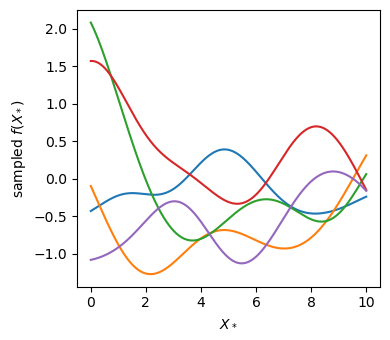

In [130]:
X = np.linspace(0, 10, 1000)
cov = squared_exponential_covariance(X, l=2)
rng = np.random.default_rng(seed=0)
y = rng.multivariate_normal(mean=np.zeros(X.shape[0]), cov=cov, size=5)

fig, ax = plt.subplots(figsize=(4,3.5))
for n in range(y.shape[0]):
    ax.plot(X, y[n])
ax.set_xlabel(r'$X_*$')
ax.set_ylabel(r'sampled $f(X_*)$')
plt.tight_layout()
plt.show()

- Note that at each $X_*$, the values of $f(X_*)$ averages (when sample size is large) to 0 as our mean function $m(\mathbf{X_*}) = 0$.

- we can also see the effect of scale parameter $l$ in the squared exponential covariance $k(\mathbf{x}_p, \mathbf{x}_q)=\exp(-\frac{|\mathbf{x}_p-\mathbf{x}_q|^2}{2l})$. Clearly, it controls the frequency at which the function varies. 

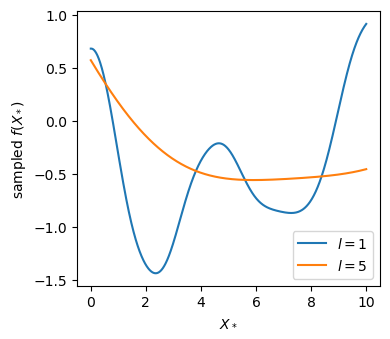

In [131]:
cov_l1 = squared_exponential_covariance(X, l=1)
cov_l5 = squared_exponential_covariance(X, l=5)

rng = np.random.default_rng(seed=0)

rng.multivariate_normal(mean=np.zeros(X.shape[0]), cov=cov_l5, size=1)

fig, ax = plt.subplots(figsize=(4,3.5))

ax.plot(X, rng.multivariate_normal(mean=np.zeros(X.shape[0]), cov=cov_l1, size=1)[0], label=r'$l=1$')
ax.plot(X, rng.multivariate_normal(mean=np.zeros(X.shape[0]), cov=cov_l5, size=1)[0], label=r'$l=5$')
ax.set_xlabel(r'$X_*$')
ax.set_ylabel(r'sampled $f(X_*)$')
ax.legend()
plt.tight_layout()
plt.show()

#### 3. Machine learning
In practice, we have a dataset $\{X_i, f(X_i)| i=0,1,\cdots, N\}$. Our goal would be to train a model using the existing data and apply to new data. The function value $f(X_*)$ in the previous section is sampled from a **prior** distribution which is a multivariate gaussian.  Mathematically, the joint distribution of training and test point, according to the prior, is written as 

\begin{gather*}
\begin{bmatrix}
y\\f_* 
\end{bmatrix}
\sim
\mathcal{N}\bigg(
    \begin{bmatrix}
    0\\0
    \end{bmatrix}
    ,\begin{bmatrix}
    K(X,X) + \sigma^2_n\mathbb{I}& K(X, X_*)\\K(X_*, X) & K(X_*, X_*)
    \end{bmatrix}
\bigg)
\end{gather*}
where the subscript * indicates test points and $\sigma_n$ on the diagonal of the training data refers to the noise from measurement. What we want to calculate is a **posterior** which tells us the probability distribution at test data point, i.e. $f_* | y, X, X_*$.


The posterior can be calculated according to [appendix-A.2](http://gaussianprocess.org/gpml/chapters/RWA.pdf). Let $\mathbf{x}, \mathbf{y}$ be a joint gaussian random vector
\begin{gather*}
\begin{bmatrix}
\mathbf{x}\\ \mathbf{y}
\end{bmatrix}
\sim \mathcal{N}\bigg(
    \begin{bmatrix}
    \mathbf{\mu}_x\\ \mathbf{\mu}_y
    \end{bmatrix},
    \begin{bmatrix}
    A&C\\C^T&B
    \end{bmatrix}
\bigg)
\end{gather*}
Then, $\mathbf{x}$ and $\mathbf{y}$ each follow gaussian distribution and the conditional distribution is also gaussian which is given by $\mathbf{x}|\mathbf{y} \sim \mathcal{N}(\bar{x}, \text{cov}(x))$ with
\begin{gather*}
\bar{x} = \mathbf{\mu}_x + CB^{-1}(\mathbf{y}-\mathbf{\mu}_y) \\
\text{cov}(x) = A - C B^{-1}C^T
\end{gather*}

In our case, we want $\mathbf{y}|\mathbf{x}$ and mean 0. It is obvious to see 
\begin{gather*}
f_*| f, X, X_* = \mathcal{N}(\bar{f}_*, \text{cov}(f_*))
\end{gather*}
where 
\begin{gather*}
\bar{f}_* = K(X_*,X) ([K(X,X)+\sigma_n^2\mathbb{I}]^{-1}\mathbf{y}
\\
\text{cov}(f_*) = K(X_*,X_*) - K(X_*,X)[K(X,X) + \sigma_n^2\mathbb{I}]K(X,X_*)
\end{gather*}

With a posterior, we can then 
- directly draw samples randomly which yields for instance, a band around a 1D plot. 
- take the mean function as prediction with error defined according to the covariance function

We can also find the marginal likelihood (the normalization term) given that our prior is $f | \mathbf{X}\sim \mathcal{N}(\mathbf{0}, K)$ and the likelihood is naturally given by $\mathbf{y} | f, X\sim \mathbf{N}(f, \sigma_n^2\mathbb{I})$ (or derived [rigorously](https://math.stackexchange.com/questions/3954080/explanation-of-marginal-likelihood-in-gaussian-process)). 

<!-- \begin{align*}
p(\mathbf{y}|\mathbf{X}) &= \int p(\mathbf{y}|f,X) p(f|\mathbf{X})df\\
&= \int \mathcal{N}(y|f,\sigma_n^2\mathbb{I}) \mathcal{N}(f|\mathbf{0}, K)df\\
&\propto \int \exp(-\frac{1}{2}(y-f)^T\sigma_n^2(y-f))\exp(-\frac{1}{2} f^TK^{-1}f)df\\
&= e^{-y^T\sigma_n^2y/2}\int \exp\bigg[ -\frac{1}{2} f^T( K^{-1}+\sigma_n^2\mathbb{I})f - y^Tf\bigg]df\\
&= e^{-y^T\sigma_n^2y/2}\int \exp\bigg[-\frac{1}{2} (f-(K^{-1}+\sigma_n^2\mathbb{I})^{-1}y)^T(K+\sigma_n^2\mathbb{I})^{-1}(f-(K^{-1}+\sigma_n^2\mathbb{I})^{-1}y)\bigg] \exp(-\frac{1}{2} y^T(K^{-1}+\sigma_n^2\mathbb{I})^{-1}y)df\\
&\propto \exp\bigg[-\frac{1}{2} y^T(\sigma_n^2\mathbb{I} + (K^{-1} + \sigma_n^2\mathbb{I})^{-1})y\bigg]
\end{align*} -->
 
\begin{gather*}
\log p(\mathbf{y}|f,X) p(f|\mathbf{X}) = -\frac{1}{2}y^T(K+\sigma_n^2)^{-1}y -\frac{1}{2} \log|K|-\frac{n}{2}\log 2\pi
\end{gather*}

The alogrithm is showned in p.19 of the [reference book](http://gaussianprocess.org/gpml/chapters/RW2.pdf).

In [236]:
from scipy.linalg import cho_solve, cholesky, solve_triangular
from typing import Literal

class GaussianProcessScratch:
    # has to be True
    CHO_USE_LOWER = True
    # CHO_USE_LOWER = False

    def __init__(self, kernel_type:Literal['RBF']='RBF', noise=0.1, **kernel_parameters):
        """
        Parameters
        ----------
        kernel_type : str, optional
            Kernel function to use, by default 'RBF'
        noise : float, optional
            Noise parameter, by default 0.1
        kernel_parameters : dict
            Kernel parameters, for `RBF` kernel, `l` is the length scale parameter.
        """
        self.kernel_type = kernel_type
        self.kernel_params = dict()
        self.noise = noise
        if kernel_type == 'RBF':
            self.kernel_function = squared_exponential_covariance
            self.kernel_params.update(kernel_parameters)
            if 'l' not in self.kernel_params:
                self.kernel_params['l'] = 1.
        else:
            raise NotImplementedError('Only RBF kernel is implemented.')
        
    def fit(self, X, y):
        """ 
        Parameters
        ----------
        X : array-like, shape (D, N)
            Training data.
        y : array-like, shape (N,)
            Training targets.
        Return
        ------
        self : object
            Returns fitted GaussianProcess object.
        """
        K = self.kernel_function(X=X, l=self.kernel_params['l'])
        K[np.diag_indices_from(K)] += self.noise

        L = cholesky(K, lower=self.CHO_USE_LOWER, check_finite=False)
        # check if L is triangular in the upper triangle
        assert np.allclose(L, np.triu(L)) or np.allclose(L, np.tril(L)), 'L is not triangular.'

        alpha = cho_solve((L, self.CHO_USE_LOWER), y, check_finite=False)

        log_marginal_likelihood = -0.5 * np.dot(y, alpha) - np.sum(np.log(np.diag(L))) - 0.5 * y.shape[0] * np.log(2 * np.pi)

        self.X_train = X
        self.y_train = y
        self.K = K
        self.L = L
        self.alpha = alpha
        self.log_marginal_likelihood = log_marginal_likelihood
        return self
    
    def predict(self, X):
        """ predict y with the mean and variance function from the posterior distribution.
        Parameters
        ----------
        X : array-like, shape (D, N)
            Data matrix.
        Return
        ------
        y : array-like, shape (N,)
            Predicted values.
        """
        Kss = self.kernel_function(X=X, l=self.kernel_params['l'])
        # check if Kss is positive-definite and symmetric
        # assert np.allclose(Kss, Kss.T) and np.all(np.linalg.eigvals(Kss) > 0), 'Kss is not positive-definite and symmetric.'
        
        Ks = self.kernel_function(X=self.X_train, Xs=X, l=self.kernel_params['l'])

        mean = Ks.T @ self.alpha
        v = solve_triangular(self.L, Ks, lower=self.CHO_USE_LOWER, check_finite=False)
        cov = Kss - v.T @ v
        return mean, cov
        
    def sample_posterior(self, X, seed=0, sample_size=1):
        """Sample from the posterior distribution.
        Parameters
        ----------
        X : array-like, shape (D, N)
            Data matrix.
        seed : int, optional
            Random seed, by default 0
        Return
        ------
        y : array-like, shape (sample_size, N)
            Sampled values.
        """
        mean, cov = self.predict(X)
        rng = np.random.default_rng(seed=seed)
        return rng.multivariate_normal(mean=mean, cov=cov, size=sample_size)
    

#### 4. Illustration
For convenience, I borrow the training data from [here](https://groups.nscl.msu.edu/hira/fanurs/progress/20210313_ipynb.html), which is defined as 
\begin{gather*}
f(x) = a \sin(x+b)
\end{gather*}
where parameters $a, b$ are randomly assigned in the range $a\in (0.5,1.0)$ and $b\in (0,1)$

In [237]:
# generate data
import pandas as pd
def toy_model(x, a, b):
    return a * np.sin(x + b)

a_range = [0.5, 1.0]
b_range = [0.0, 1.0]
x_range = [0.0, 1.0]
np.random.seed(4)
a_true = np.random.uniform(*a_range)
b_true = np.random.uniform(*b_range)
def eps_true(x): return 0.09 * x + 0.01

df_data = pd.DataFrame({'x': np.linspace(0, 1, 11)})
df_data['f_exact'] = toy_model(df_data['x'], a_true, b_true)
df_data['ferr'] = eps_true(df_data['x'])
df_data['f_dev'] = [np.random.normal(scale=err) for err in df_data['ferr']]
df_data['f'] = df_data['f_exact'] + df_data['f_dev']
print(df_data)

      x   f_exact   ferr     f_dev         f
0   0.0  0.511748  0.010 -0.009959  0.501789
1   0.1  0.593041  0.019  0.013178  0.606219
2   0.2  0.668408  0.028 -0.011712  0.656695
3   0.3  0.737096  0.037 -0.058629  0.678467
4   0.4  0.798420  0.046 -0.029795  0.768625
5   0.5  0.851766  0.055  0.032922  0.884688
6   0.6  0.896602  0.064  0.021264  0.917866
7   0.7  0.932479  0.073 -0.083766  0.848713
8   0.8  0.959039  0.082  0.050731  1.009770
9   0.9  0.976016  0.091 -0.008007  0.968009
10  1.0  0.983242  0.100  0.042507  1.025749


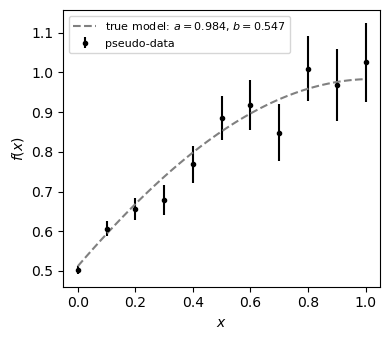

In [238]:
# visoulize data
fig, ax = plt.subplots(figsize=(4,3.5))
ax.errorbar(df_data['x'], df_data['f'], yerr=df_data['ferr'],
            color='black', markersize=3, fmt='o', label='pseudo-data')
x_plt = np.linspace(*x_range, 100)
ax.plot(x_plt, toy_model(x_plt, a_true, b_true), color='gray', linestyle='dashed',
        label=r'true model: $a={a:.3f}$, $b={b:.3f}$'.format(a=a_true, b=b_true))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.legend(fontsize=8, loc='upper left')
plt.tight_layout()
plt.show()

In [239]:
# start fitting with GaussianProcessScratch
gpr = GaussianProcessScratch(kernel_type='RBF', kernel_parameters={'l': 1.})
gpr.fit(df_data['x'], df_data['f'])
X_test = np.linspace(*x_range, 100)
y_test, cov_test = gpr.predict(X=X_test)

# same fitting with sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
skgpr = GaussianProcessRegressor(alpha=0.1)
skgpr.fit(df_data['x'].to_numpy().reshape(-1,1), df_data['f'].to_numpy().reshape(-1,1))
y_test_sklearn, std_test_sklearn = skgpr.predict(X_test.reshape(-1,1), return_std=True)
y_test_sklearn, cov_test_sklearn = skgpr.predict(X_test.reshape(-1,1), return_cov=True)


L is triangular in the lower triangle.


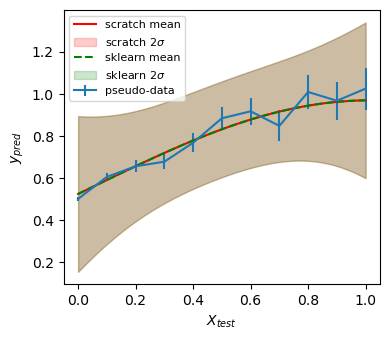

In [240]:
# visulize the result
fig, ax = plt.subplots(figsize=(4,3.5))
ax.errorbar(df_data['x'], df_data['f'], yerr=df_data['ferr'], label='pseudo-data')
ax.plot(X_test, y_test, label='scratch mean', color='r')
ax.fill_between(X_test, y_test - 2 * np.sqrt(np.diag(cov_test)), y_test + 2 * np.sqrt(np.diag(cov_test)), alpha=0.2, color='r', label=r'scratch 2$\sigma$')
ax.plot(X_test, skgpr.predict(X_test.reshape(-1,1)), ls='--', label='sklearn mean', color='g')
ax.fill_between(X_test, y_test_sklearn - 2 * std_test_sklearn, y_test_sklearn + 2 * std_test_sklearn, alpha=0.2, color='g', label=r'sklearn 2$\sigma$')
ax.set_xlabel(r'$X_{test}$')
ax.set_ylabel(r'$y_{pred}$')
ax.legend(fontsize=8, loc='upper left')
plt.tight_layout()
plt.show()

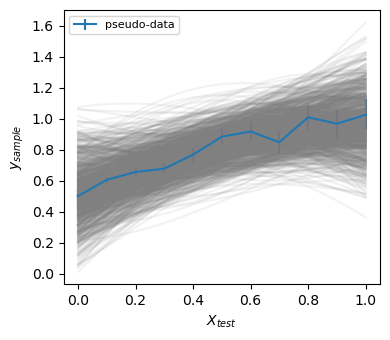

In [248]:
# directly sample from the posterior
N = 1000
samples = gpr.sample_posterior(X_test, seed=0, sample_size=N)
fig, ax = plt.subplots(figsize=(4,3.5))
ax.errorbar(df_data['x'], df_data['f'], yerr=df_data['ferr'], label='pseudo-data')
for i in range(N):
    ax.plot(X_test, samples[i], color='gray', alpha=0.1)
ax.set_xlabel(r'$X_{test}$')
ax.set_ylabel(r'$y_{sample}$')
ax.legend(fontsize=8, loc='upper left')
plt.tight_layout()
plt.show()
